In [1]:
import numpy as np
import datetime
import xarray as xr
import pandas as pd
import sys, glob, os, re, subprocess
import matplotlib
import matplotlib.pyplot as plt
import imageio
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def set_background(ax):
    ax.set_extent([-121, -72, 25, 50])

    # Background boundaries
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    
    return ax

# Load emulator CV reslts: RF and GPR

In [2]:
inpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO'
basinnum = 627
iternum = 9

# 2: GPR, RF; 
# 6: 5-folders+mean, 
# 3: kge1 (mean abs err), kge2 (max monthly abs err), kge_mean (1,2)
metrics = np.nan * np.zeros([basinnum, iternum, 2, 6, 3]) 


for i in range(basinnum):
    for j in range(iternum):
        infiles_ij = [f'{inpath}/level1_{i}_MOASMOcalib/param_sets/GPR_for_iter{j}_CV_kge.csv', 
                      f'{inpath}/level1_{i}_MOASMOcalib/param_sets/RF_for_iter{j}_CV_kge.csv']
        for p in range(2):
            infile_ijp = infiles_ij[p]
            df = pd.read_csv(infile_ijp)
            metrics[i, j, p, :, :] = df.values[:,1:]


In [3]:
# basin info
file = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
ds_info = pd.read_csv(file)
ds_info.head()

,hru_id,ann_P,lon_cen,lat_cen,AREA,elev_mean,ave_T,july_T,Perimeter,Source,...,RawTDXarea,HSTDXarea,MHTDXarea,RawCAMELSbias,RawTDXbias,HSTDXbias,MHTDXbias,final_bias,geometry,file_obsQ
0,1013500,0.0,-68.56551,47.01169,2.303988e+09,277.493490,NaN,NaN,647993,RawTDX,...,2246.946668,2246.628415,2246.132802,0.022767,-0.002554,-0.002695,-0.002915,0.002554,POLYGON ((-68.84000529335947 46.73746031546882...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...
1,1022500,0.0,-68.07313,44.79691,6.203873e+08,103.604200,NaN,NaN,312624,HSTDX,...,615.173865,586.427404,586.602450,0.081568,0.072479,0.022363,0.022668,0.022363,POLYGON ((-68.13005554673525 44.64716666195261...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...
2,1030500,0.0,-68.14985,45.80527,3.676155e+09,174.433896,NaN,NaN,662248,RawCAMELS,...,3654.475429,3653.788946,3653.845830,-0.000004,-0.005901,-0.006088,-0.006073,0.000004,POLYGON ((-68.35800170861474 45.67902755716805...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...
3,1031500,0.0,-69.58119,45.23568,7.665447e+08,304.743490,NaN,NaN,309614,RawCAMELS,...,775.632787,772.001421,772.168545,-0.003258,0.008560,0.003838,0.004055,0.003258,POLYGON ((-69.67646789509475 45.14558029212971...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...
4,1047000,0.0,-70.16213,44.98744,9.049562e+08,379.779978,NaN,NaN,310157,RawCAMELS,...,914.491471,914.237495,913.814091,-0.004558,0.005931,0.005651,0.005185,0.004558,POLYGON ((-70.10847473135688 45.21669387774366...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...


# Variation of GPR/RF ratio with iterations

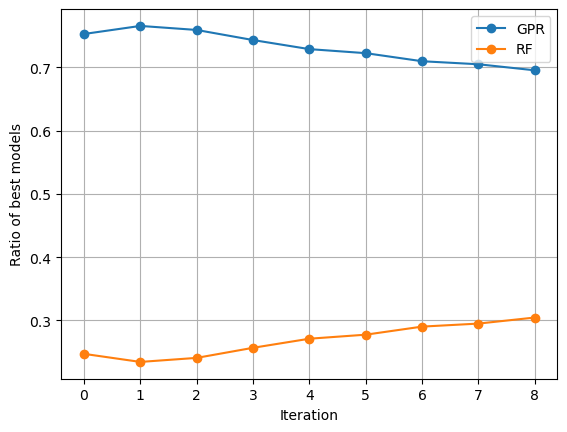

In [4]:
gpr_ratio = np.zeros(iternum)
for j in range(iternum):
    met = metrics[:,j,:,-1,-1]
    gpr_ratio[j] = np.sum(met[:,0]>met[:,1]) / np.sum(~np.isnan(met[:,0]))

rf_ratio = 1 - gpr_ratio

plt.plot(gpr_ratio, '-o', label='GPR')
plt.plot(rf_ratio, '-o', label='RF')
plt.xlabel('Iteration')
plt.ylabel('Ratio of best models')
plt.legend()
plt.grid('on')
# plt.savefig('best_model_ratio_with_iterations.png', dpi=600, bbox_inches='tight', pad_inches=0)
# plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


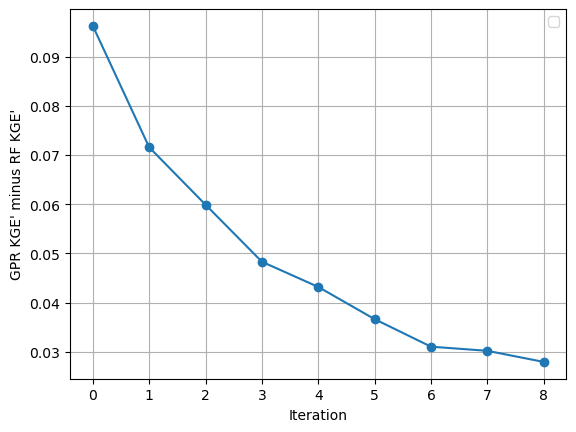

In [5]:
kge_diff = np.zeros(iternum)
for j in range(iternum):
    met = metrics[:,j,:,-1,-1]
    kge_diff[j] = np.nanmedian(met[:,0] - met[:,1]) 


plt.plot(kge_diff, '-o')
plt.xlabel('Iteration')
plt.ylabel("GPR KGE' minus RF KGE'")
plt.legend()
plt.grid('on')
# plt.savefig('median_kge_difference_GPRvsRF.png', dpi=600, bbox_inches='tight', pad_inches=0)
# plt.show()

# Spatial distribution of GPR/RF

In [6]:
lat = ds_info['lat_cen'].values
lon = ds_info['lon_cen'].values

met = metrics[:,0,:,-1,-1]

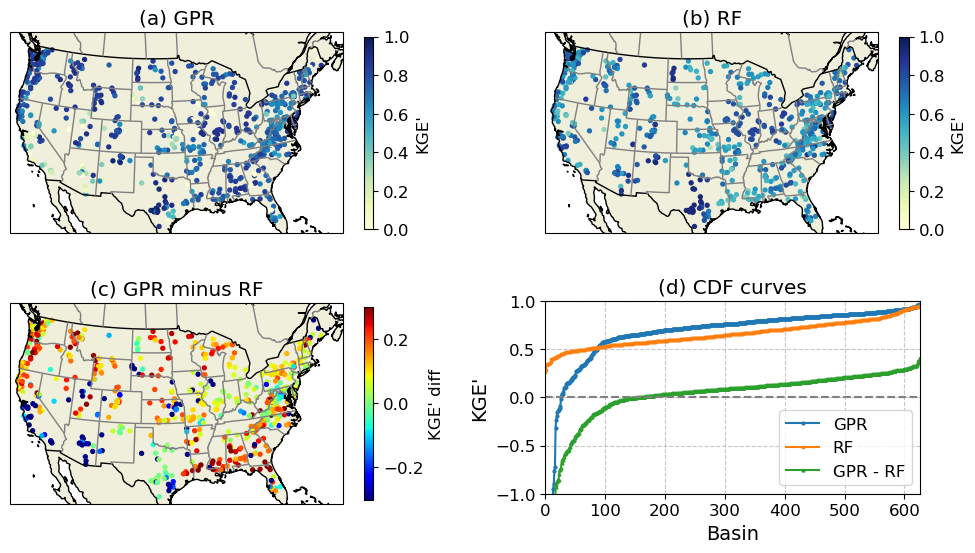

In [25]:
font = {'size'   : 12}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, 6])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

ax = fig.add_subplot(2, 2, 1, projection=proj)
ax = set_background(ax)
p = ax.scatter(lon, lat, 8, met[:,0], cmap='YlGnBu', vmin=0, vmax=1, transform=transf)
ax.set_title('(a) GPR')
cax = plt.colorbar(p, ax=ax, label="KGE'", location='right', shrink=0.8)

ax = fig.add_subplot(2, 2, 2, projection=proj)
ax = set_background(ax)
p = ax.scatter(lon, lat, 8, met[:,1], cmap='YlGnBu', vmin=0, vmax=1, transform=transf)
ax.set_title('(b) RF')
cax = plt.colorbar(p, ax=ax, label="KGE'", location='right', shrink=0.8)

ax = fig.add_subplot(2, 2, 3, projection=proj)
ax = set_background(ax)
p = ax.scatter(lon, lat, 8, met[:,0] - met[:,1], cmap='jet', vmin=-0.3, vmax=0.3, transform=transf)
ax.set_title('(c) GPR minus RF')
cax = plt.colorbar(p, ax=ax, label="KGE' diff", location='right', shrink=0.8)

ax4 = fig.add_subplot(2, 2, 4)
plt.plot(np.sort(met[:, 0]), label='GPR', marker='o', linestyle='-', markersize=2)
plt.plot(np.sort(met[:, 1]), label='RF', marker='s', linestyle='-', markersize=2)
plt.plot(np.sort(met[:, 0] - met[:, 1]), label='GPR - RF', marker='^', linestyle='-', markersize=2)
plt.plot([0, 626], [0, 0], color='grey', linestyle='--')
plt.ylim([-1, 1])
plt.xlim([0, 626])
plt.xlabel('Basin', fontsize=14)
plt.ylabel("KGE'", fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
ax4.set_title('(d) CDF curves')

plt.tight_layout()

pos1 = ax4.get_position()  # Get the original position
pos2 = [pos1.x0, pos1.y0+0.05, pos1.width*0.9, pos1.height * 0.8]  # Modify the height
ax4.set_position(pos2)  # Set the new position

plt.savefig('iteration0_GRP_minus_RF.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

# GPR/RF differences with iterations

In [9]:
lat = ds_info['lat_cen'].values
lon = ds_info['lon_cen'].values

In [ ]:
# Directory to save frames
frames_dir = 'frames'
os.makedirs(frames_dir, exist_ok=True)

# Create and save each frame
for i in range(iternum):
    font = {'size': 12}
    plt.rc('font', **font)
    
    fig = plt.figure(figsize=[10, 6])
    
    proj = ccrs.AlbersEqualArea(central_longitude=-100)
    transf = ccrs.PlateCarree()
    
    met = metrics[:,i,:,-1,-1]
    
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(lon, lat, 20, met[:, 0] - met[:, 1], cmap='jet', vmin=-0.3, vmax=0.3, transform=transf)
    ax.set_title(f'GPR minus RF: Iteration {i}')
    cax = plt.colorbar(p, ax=ax, label="KGE' diff", location='right', shrink=0.8)

    
    # Save the frame
    frame_path = os.path.join(frames_dir, f'frame_{i:03d}.png')
    plt.savefig(frame_path)
    plt.close(fig)

# Create GIF
frames = [imageio.imread(os.path.join(frames_dir, f'frame_{i:03d}.png')) for i in range(iternum)]
gif_path = 'iteration0-8_GRP_minus_RF.gif'
imageio.mimsave(gif_path, frames, duration=400,loop=0)  # Adjust duration to set the time interval for the GIF
_ = os.system(f'rm -r {frames_dir}')

# Example of terrible GPR in cross validation

In [64]:
met = metrics[:, 0, :, -1, -1]
ind = np.where(met[:,0]-met[:,1]<-0.5)[0]

,hru_id,ann_P,lon_cen,lat_cen,AREA,elev_mean,ave_T,july_T,Perimeter,Source,...,RawTDXarea,HSTDXarea,MHTDXarea,RawCAMELSbias,RawTDXbias,HSTDXbias,MHTDXbias,final_bias,geometry,file_obsQ
0,1013500,0.0,-68.56551,47.01169,2.303988e+09,277.49349,NaN,NaN,647993,RawTDX,...,2246.946668,2246.628415,2246.132802,0.022767,-0.002554,-0.002695,-0.002915,0.002554,POLYGON ((-68.84000529335947 46.73746031546882...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...


GRP emulator CV kge


,metric-1,metric-2,mean
Fold-1,0.83,0.61,0.72
Fold-2,0.87,0.70,0.79
Fold-3,0.90,0.86,0.88
Fold-4,0.82,0.69,0.76
Fold-5,-46.30,0.61,-22.84
Mean,-8.58,0.70,-3.94


RF emulator CV kge


,metric-1,metric-2,mean
Fold-1,0.71,0.69,0.70
Fold-2,0.74,0.68,0.71
Fold-3,0.76,0.79,0.78
Fold-4,0.70,0.69,0.69
Fold-5,0.71,0.76,0.74
Mean,0.73,0.72,0.72


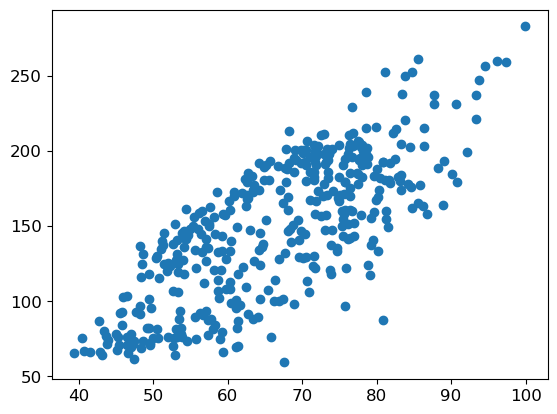

In [96]:
tarbasin = 0
tariter = 0
met_gpr = metrics[tarbasin, tariter, 0, :, :]
met_rf = metrics[tarbasin, tariter, 1, :, :]

display(ds_info.iloc[[tarbasin]])

print('GRP emulator CV kge')
df_gpr = pd.DataFrame(met_gpr, columns = ['metric-1', 'metric-2', 'mean'], index = ['Fold-1', 'Fold-2', 'Fold-3', 'Fold-4', 'Fold-5', 'Mean'])
display(df_gpr.round(2))

print('RF emulator CV kge')
df_rf = pd.DataFrame(met_rf, columns = ['metric-1', 'metric-2', 'mean'], index = ['Fold-1', 'Fold-2', 'Fold-3', 'Fold-4', 'Fold-5', 'Mean'])
display(df_rf.round(2))


# load metrics (just-iter0)
file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO/level1_{tarbasin}_MOASMOcalib/ctsm_outputs/iter0_all_metric.csv'
df_metrics = pd.read_csv(file)
plt.scatter(df_metrics['metric1'], df_metrics['metric2'])